In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, F1Score, AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def segmentation(img):
    ## Segmentasi
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # blurred = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.convertScaleAbs(img)

    # Apply Otsu's Thresholding
    ret, thresholded_image = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    thresholded_image = np.float32(thresholded_image)
    thresholded_image = np.stack([thresholded_image] * 3, axis=-1)
     
    return thresholded_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


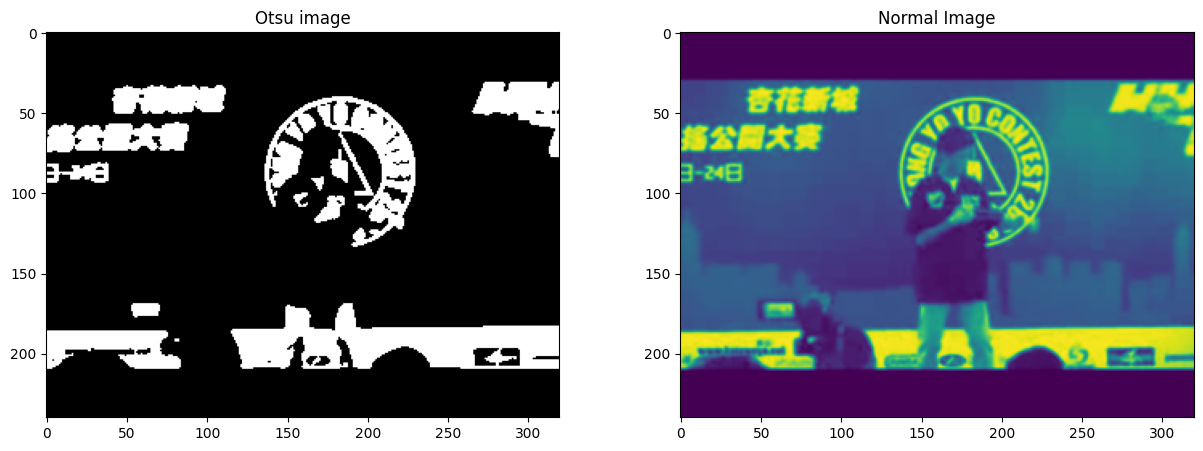

In [3]:
img = cv2.imread('./output/gaussian_cs/YoYo/v_YoYo_g01_c02/frame_0002.png')
grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
otsu = segmentation(grayscale)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(otsu)
plt.title('Otsu image')
plt.subplot(1,2,2)
plt.imshow(grayscale)
plt.title('Normal Image')
plt.show()

### Without Segmentation

In [ ]:
train_datagen = ImageDataGenerator(
    # preprocessing_function=segmentation,
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=0.2,
    fill_mode='wrap',
    shuffle=True,
    seed=42
)

train_generator = train_datagen.flow_from_directory(
    './output/gaussian_cs',
    target_size=(299,299),
    batch_size=32,
    class_mode = 'categorical',
    subset='training',
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_generator = val_datagen.flow_from_directory(
    './output/gaussian_cs',
    target_size=(299,299),   
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)

Found 50627 images belonging to 2 classes.
Found 12656 images belonging to 2 classes.


In [11]:
train_generator.class_indices

{'PlayingGuitar': 0, 'YoYo': 1}

In [9]:
unique_classes, class_frequencies = np.unique(train_generator.classes, return_counts=True)
print("Class distribution:", dict(zip(unique_classes, class_frequencies)))

Class distribution: {np.int32(0): np.int64(31947), np.int32(1): np.int64(18680)}


In [12]:
unique_classes, class_frequencies = np.unique(val_generator.classes, return_counts=True)
print("Class distribution:", dict(zip(unique_classes, class_frequencies)))

Class distribution: {np.int32(0): np.int64(7986), np.int32(1): np.int64(4670)}


In [28]:
stopping = EarlyStopping(
    monitor= 'val_loss',
    patience= 3,
    restore_best_weights= True
)

checkpoints = ModelCheckpoint(
    'best_model_non_segmentation.keras',
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

In [29]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False
num_classes = len(train_generator.class_indices)


model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score(), AUC()])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,852,898 (87.18 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [30]:
# if os.path.exists('model_non_segmentation.keras'):
#     model = tf.keras.models.load_model('model_non_segmentation.keras')
# else:
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size,
        callbacks=[stopping, checkpoints]
    )

Epoch 1/20
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.9879 - auc_2: 0.9978 - f1_score: 0.9870 - loss: 0.0357 - precision_2: 0.9879 - recall_2: 0.9879
Epoch 1: val_loss improved from inf to 0.03986, saving model to best_model_non_segmentation.keras
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1283s 809ms/step - accuracy: 0.9879 - auc_2: 0.9978 - f1_score: 0.9870 - loss: 0.0357 - precision_2: 0.9879 - recall_2: 0.9879 - val_accuracy: 0.9801 - val_auc_2: 0.9990 - val_f1_score: 0.9789 - val_loss: 0.0399 - val_precision_2: 0.9801 - val_recall_2: 0.9801
Epoch 2/20
   1/1582 ━━━━━━━━━━━━━━━━━━━━ 13:43 521ms/step - accuracy: 1.0000 - auc_2: 1.0000 - f1_score: 1.0000 - loss: 3.6891e-04 - precision_2: 1.0000 - recall_2: 1.0000

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.03986 to 0.03930, saving model to best_model_non_segmentation.keras
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 221s 139ms/step - accuracy: 1.0000 - auc_2: 1.0000 - f1_score: 1.0000 - loss: 3.6891e-04 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.9805 - val_auc_2: 0.9990 - val_f1_score: 0.9792 - val_loss: 0.0393 - val_precision_2: 0.9805 - val_recall_2: 0.9805
Epoch 3/20
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.9996 - auc_2: 1.0000 - f1_score: 0.9996 - loss: 0.0015 - precision_2: 0.9996 - recall_2: 0.9996
Epoch 3: val_loss did not improve from 0.03930
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1275s 806ms/step - accuracy: 0.9996 - auc_2: 1.0000 - f1_score: 0.9996 - loss: 0.0015 - precision_2: 0.9996 - recall_2: 0.9996 - val_accuracy: 0.9758 - val_auc_2: 0.9986 - val_f1_score: 0.9743 - val_loss: 0.0481 - val_precision_2: 0.9758 - val_recall_2: 0.9758
Epoch 4/20
   1/1582 ━━━━━━━━━━━━━━━━━━━━ 14:30 550ms/step - accuracy: 1.0000 - auc_2: 1.0000 - f

In [31]:
# Mendapatkan nilai akurasi untuk setiap epoch dari history
train_accuracy = history.history['accuracy']  # Akurasi pada data training
val_accuracy = history.history['val_accuracy']  # Akurasi pada data validasi

# Mencetak akurasi di setiap epoch
print("Training Accuracy per Epoch:")
for epoch, acc in enumerate(train_accuracy, 1):
    print(f"Epoch {epoch}: {acc:.4f}")

print("\nValidation Accuracy per Epoch:")
for epoch, val_acc in enumerate(val_accuracy, 1):
    print(f"Epoch {epoch}: {val_acc:.4f}")

Training Accuracy per Epoch:
Epoch 1: 0.9970
Epoch 2: 1.0000
Epoch 3: 0.9996
Epoch 4: 1.0000
Epoch 5: 0.9999

Validation Accuracy per Epoch:
Epoch 1: 0.9801
Epoch 2: 0.9805
Epoch 3: 0.9758
Epoch 4: 0.9760
Epoch 5: 0.9800


In [32]:
test_images, test_labels = next(val_generator)

test_images = test_images[:10]
test_labels = test_labels[:10]

predictions = model.predict(test_images)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Tampilkan hasil prediksi untuk 10 data
for i in range(10):
    print(f"Predicted: {predicted_classes[i]}, True: {true_classes[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 1, True: 1
Predicted: 1, True: 0
Predicted: 1, True: 1
Predicted: 0, True: 0


In [33]:
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the test generator
y_true = val_generator.classes  # True class labels

# Get class names from the generator
class_names = list(val_generator.class_indices.keys())

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# Optional: Confusion matrix for additional insights
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

396/396 ━━━━━━━━━━━━━━━━━━━━ 226s 569ms/step
Classification Report:
                precision    recall  f1-score   support

PlayingGuitar       0.63      0.62      0.62      7986
         YoYo       0.37      0.39      0.38      4670

     accuracy                           0.53     12656
    macro avg       0.50      0.50      0.50     12656
 weighted avg       0.54      0.53      0.53     12656

Confusion Matrix:
 [[4915 3071]
 [2846 1824]]


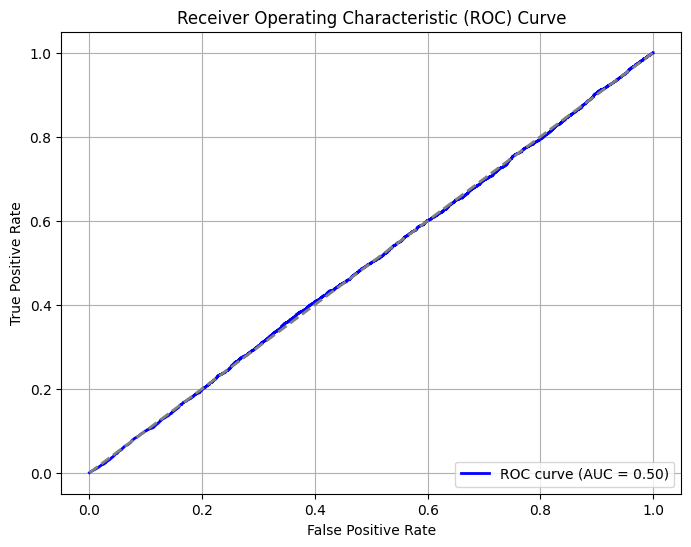

AUC: 0.50


In [34]:
y_pred_proba = y_pred[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

roc_auc = auc(fpr, tpr)

# Visualisasi ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Garis acak
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC: {roc_auc:.2f}")

In [35]:
model.save('model_non_segmentation.keras')

### Segmentation

In [36]:
train_datagen = ImageDataGenerator(
    preprocessing_function=segmentation,
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=0.2,
    fill_mode='wrap'
)

train_generator = train_datagen.flow_from_directory(
    './output/gaussian_cs',
    target_size=(299,299),
    batch_size=32,
    class_mode = 'categorical',
    subset='training',
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_generator = val_datagen.flow_from_directory(
    './output/gaussian_cs',
    target_size=(299,299),   
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)

Found 50627 images belonging to 2 classes.
Found 12656 images belonging to 2 classes.


In [37]:
stopping = EarlyStopping(
    monitor= 'val_loss',
    patience= 3,
    restore_best_weights= True
)

checkpoints = ModelCheckpoint(
    'best_model_segmentation.keras',
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

In [38]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False
num_classes = len(train_generator.class_indices)


model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score(), AUC()])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,852,898 (87.18 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [39]:
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.samples,
        callbacks=[stopping, checkpoints]
    )

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 1583/50627 ━━━━━━━━━━━━━━━━━━━━ 9:13:19 677ms/step - accuracy: 0.9567 - auc_3: 0.9844 - f1_score: 0.9531 - loss: 0.1195 - precision_3: 0.9567 - recall_3: 0.9567

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.54397, saving model to best_model_segmentation.keras
50627/50627 ━━━━━━━━━━━━━━━━━━━━ 1296s 26ms/step - accuracy: 0.9844 - auc_3: 0.9985 - f1_score: 0.9832 - loss: 0.0502 - precision_3: 0.9844 - recall_3: 0.9844 - val_accuracy: 0.8116 - val_auc_3: 0.8983 - val_f1_score: 0.8106 - val_loss: 0.5440 - val_precision_3: 0.8116 - val_recall_3: 0.8116
Epoch 2/20
 1583/50627 ━━━━━━━━━━━━━━━━━━━━ 9:14:11 678ms/step - accuracy: 0.9971 - auc_3: 0.9999 - f1_score: 0.9969 - loss: 0.0104 - precision_3: 0.9971 - recall_3: 0.9971
Epoch 2: val_loss improved from 0.54397 to 0.35760, saving model to best_model_segmentation.keras
50627/50627 ━━━━━━━━━━━━━━━━━━━━ 1293s 26ms/step - accuracy: 0.9973 - auc_3: 0.9999 - f1_score: 0.9971 - loss: 0.0095 - precision_3: 0.9973 - recall_3: 0.9973 - val_accuracy: 0.8563 - val_auc_3: 0.9492 - val_f1_score: 0.8542 - val_loss: 0.3576 - val_precision_3: 0.8563 - val_recall_3: 0.8563
Epoch 3/20
 1583/50627 ━━━━━━━━━━━━━━━━━━━━ 9:13

In [40]:
# Mendapatkan nilai akurasi untuk setiap epoch dari history
train_accuracy = history.history['accuracy']  # Akurasi pada data training
val_accuracy = history.history['val_accuracy']  # Akurasi pada data validasi

# Mencetak akurasi di setiap epoch
print("Training Accuracy per Epoch:")
for epoch, acc in enumerate(train_accuracy, 1):
    print(f"Epoch {epoch}: {acc:.4f}")

print("\nValidation Accuracy per Epoch:")
for epoch, val_acc in enumerate(val_accuracy, 1):
    print(f"Epoch {epoch}: {val_acc:.4f}")

Training Accuracy per Epoch:
Epoch 1: 0.9853
Epoch 2: 0.9974
Epoch 3: 0.9982
Epoch 4: 0.9987
Epoch 5: 0.9989
Epoch 6: 0.9989
Epoch 7: 0.9990
Epoch 8: 0.9991
Epoch 9: 0.9990
Epoch 10: 0.9992

Validation Accuracy per Epoch:
Epoch 1: 0.8116
Epoch 2: 0.8563
Epoch 3: 0.7887
Epoch 4: 0.8639
Epoch 5: 0.9060
Epoch 6: 0.7744
Epoch 7: 0.9489
Epoch 8: 0.8797
Epoch 9: 0.7954
Epoch 10: 0.8365


In [41]:
test_images, test_labels = next(val_generator)

test_images = test_images[:10]
test_labels = test_labels[:10]

predictions = model.predict(test_images)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Tampilkan hasil prediksi untuk 10 data
for i in range(10):
    print(f"Predicted: {predicted_classes[i]}, True: {true_classes[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0


In [42]:
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the test generator
y_true = val_generator.classes  # True class labels

# Get class names from the generator
class_names = list(val_generator.class_indices.keys())

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# Optional: Confusion matrix for additional insights
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

396/396 ━━━━━━━━━━━━━━━━━━━━ 224s 563ms/step
Classification Report:
                precision    recall  f1-score   support

PlayingGuitar       0.63      0.58      0.61      7986
         YoYo       0.37      0.41      0.39      4670

     accuracy                           0.52     12656
    macro avg       0.50      0.50      0.50     12656
 weighted avg       0.53      0.52      0.53     12656

Confusion Matrix:
 [[4661 3325]
 [2734 1936]]


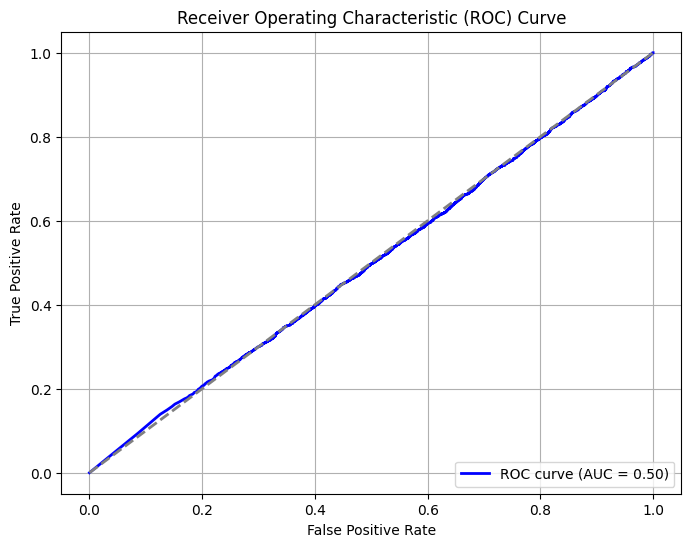

AUC: 0.50


In [43]:
y_pred_proba = y_pred[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

roc_auc = auc(fpr, tpr)

# Visualisasi ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Garis acak
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC: {roc_auc:.2f}")

In [44]:
model.save('model_segmentation.keras')